## Methods notebook

point of this notebook is to take the ideas from the working notebook to make some methods

In [1]:
#############################Import Block#############################
import matplotlib.pyplot as plt #plotting
from pathlib import Path #paths
import glob #glob files
import os #system commands in case we need it
import numpy as np #handling numbers if needed
import pandas as pd #handling data in dataframes
import pytraj as pt #cpptraj, but python
from pymol import cmd,stored #pymol commands and stuffs
import scipy.stats as stats #for stats.entropy
#############################Import Block#############################

In [37]:
class proteinAnalysis:
    '''
    Class definition for protein and ligand analysis
    '''
    time = []
    resnames = []
    resids = []
    ligresn = []
    ligresi = []
    bb_rmsd = []
    ha_rmsd = []
    sc_rmsd = []
    ca_rmsd = []
    byres_ca_rmsd = []
    byres_bb_rmsd = []
    byres_sc_rmsd = []
    byres_ha_rmsd = []
    byres_ca_rmsd_avg = []
    byres_bb_rmsd_avg = []
    byres_sc_rmsd_avg = []
    byres_ha_rmsd_avg = []
    byres_ca_rmsd_std = []
    byres_bb_rmsd_std = []
    byres_sc_rmsd_std = []
    byres_ha_rmsd_std = []
    byres_ca_rmsd_std1 = []
    byres_bb_rmsd_std1 = []
    byres_sc_rmsd_std1 = []
    byres_ha_rmsd_std1 = []
    byres_ca_rmsd_std2 = []
    byres_bb_rmsd_std2 = []
    byres_sc_rmsd_std2 = []
    byres_ha_rmsd_std2 = []
    byres_bb_dih = [] #backbone
    byres_sc_dih = [] #sidechain
    byres_bb_dih_avg = []
    byres_bb_dih_std = []
    byres_bb_dih_std1 = []
    byres_bb_dih_std2 = []
    byres_sc_dih_avg = []
    byres_sc_dih_std = []
    byres_sc_dih_std1 = []
    byres_sc_dih_std2 = []
    trajectory = None
    ref = None
    out_dir = None
    timestep = 10
    def __init__(self, refPdb, outDir, timestep = 10):
        '''
        initialization of class should require a reference pdb. 
        This should be the xtal or first frame
        
        refPdb = reference pdb, xtal or first frame
        timestep = time step of frames provided, default to 10 ps
        '''
        stored.list = []
        iresnames = []
        iresids = []
        iligresn = []
        iligresi = []
        cmd.reinitialize()
        cmd.load(refPdb)
        cmd.select('protein-residues', 'polymer.protein and name CA')
        cmd.iterate('protein-residues', 'stored.list.append((resi, resn))')
        for k,tup in enumerate(stored.list):
            iresnames.append(tup[1])
            iresids.append(tup[0])
        stored.list = []
        unwanted_organics = ['GOL','EDO', 'ACE', 'NME'] #add to the list as we go
        cmd.select('ligand', 'organic')
        cmd.iterate('ligand', 'stored.list.append((resi, resn))')
        for k,tup in enumerate(stored.list):
            if tup[1] not in unwanted_organics:
                iligresn.append(tup[1])
                iligresi.append(tup[0])
        self.resnames = iresnames
        self.resids = iresids
        self.ligresn = iligresn
        self.ligresi = iligresi
        self.ref = pt.load(refPdb)
        self.out_dir = outDir
        self.timestep = timestep
    def loadTrajectory(self, traj, top, align=None):
        '''
        Method to load trajectory and align as needed, maybe should be in init
        
        align is a string that defines by how the structure should be aligned
        
        eg '@CA' for alpha carbons
        '''
        self.trajectory = pt.load(traj, top)
        if align is not None:
            self.trajectory = pt.align(self.trajectory, align, self.ref)

    def plotProteinRMSD(self):
        '''
        Method to generate rmsd plots for whole protein
        '''
        df = pd.DataFrame()
        ca_rms = pt.rmsd_nofit(self.trajectory, mask='@CA')
        bb_rms = pt.rmsd_nofit(self.trajectory, mask='!:HOH,WAT&@CA,C,N,O')
        ha_rms = pt.rmsd_nofit(self.trajectory, mask='!:HOH,WAT&!@H=')
        sc_rms = pt.rmsd_nofit(self.trajectory, mask='!:HOH,WAT&!@CA,C,N,O')
        for k,rms in enumerate(ca_rms):
            self.time.append(int(k * self.timestep))
            self.ca_rmsd.append(rms)
            self.ha_rmsd.append(ha_rms[k])
            self.bb_rmsd.append(bb_rms[k])
            self.sc_rmsd.append(sc_rms[k])
        f1 = plt.figure()
        plt.plot(self.time, self.ca_rmsd, 'b-')
        plt.xlabel('time (ps)')
        plt.ylabel('CA rmsd (Å)')
        plt.savefig(str(self.out_dir / 'protein_CA_rmsd.png'))
        f2 = plt.figure()
        plt.plot(self.time, self.bb_rmsd, 'b-')
        plt.xlabel('time (ps)')
        plt.ylabel('BB rmsd (Å)')
        plt.savefig(str(self.out_dir / 'protein_BB_rmsd.png'))
        f3 = plt.figure()
        plt.plot(self.time, self.sc_rmsd, 'b-')
        plt.xlabel('time (ps)')
        plt.ylabel('SC rmsd (Å)')
        plt.savefig(str(self.out_dir / 'protein_SC_rmsd.png'))
        f4 = plt.figure()
        plt.plot(self.time, self.ha_rmsd, 'b-')
        plt.xlabel('time (ps)')
        plt.ylabel('HA rmsd (Å)')
        plt.savefig(str(self.out_dir / 'protein_HA_rmsd.png'))
        df['simtime'] = self.time
        df['CA RMSD (Å)'] = self.ca_rmsd
        df['BB RMSD (Å)'] = self.bb_rmsd
        df['SC RMSD (Å)'] = self.sc_rmsd
        df['HA RMSD (Å)'] = self.ha_rmsd
        df.to_csv(str(self.out_dir / 'proteinRMSD.csv'), index=False)
        return
        
    def plotLigandRMSD(self):
        '''
        Method to generate ligand rmsd (provided there is a ligand)
        '''
        if len(ligresn) == 0:
            print('No ligand in system check initialization')
            return
        df = pd.DataFrame()
        lig_rms = pt.rmsd_nofit(self.trajectory, mask=f':{self.ligresn[0]}')
        plt.plot(self.time, lig_rms, 'b-')
        plt.xlabel('time (ps)')
        plt.ylabel('ligand rmsd (Å)')
        plt.savefig(str(self.out_dir / 'ligand_rmsd.png'))
        df['simtime'] = self.time
        df['ligand RMSD (Å)'] = lig_rms
        df.to_csv(str(self.out_dir / 'ligandRMSD.csv'), index=False)
        return
    
    def plotByResRMSD(self):
        '''
        Method to plot by residue rmsds
        '''
        for k,res in enumerate(self.resids):
            ca = pt.rmsd_nofit(self.trajectory, mask=f':{res}&@CA')
            bb = pt.rmsd_nofit(self.trajectory, mask=f':{res}&@CA,C,N,O&!:HOH,WAT')
            sc = pt.rmsd_nofit(self.trajectory, mask=f':{res}&!@CA,C,N,O&!:HOH,WAT')
            ha = pt.rmsd_nofit(self.trajectory, mask=f':{res}&!:HOH,WAT&!@H=')
            ca_avg = np.mean(ca)
            bb_avg = np.mean(bb)
            sc_avg = np.mean(sc)
            ha_avg = np.mean(ha)
            ca_std = np.std(ca)
            bb_std = np.std(bb)
            sc_std = np.std(sc)
            ha_std = np.std(ha)
            ca_std1 = np.std(ca[:int(len(ca)/2)])
            bb_std1 = np.std(bb[:int(len(ca)/2)])
            sc_std1 = np.std(sc[:int(len(ca)/2)])
            ha_std1 = np.std(ha[:int(len(ca)/2)])
            ca_std2 = np.std(ca[int(len(ca)/2):])
            bb_std2 = np.std(bb[int(len(ca)/2):])
            sc_std2 = np.std(sc[int(len(ca)/2):])
            ha_std2 = np.std(ha[int(len(ca)/2):])
            self.byres_ca_rmsd.append(ca)
            self.byres_bb_rmsd.append(bb)
            self.byres_sc_rmsd.append(sc)
            self.byres_ha_rmsd.append(ha)
            self.byres_ca_rmsd_avg.append(ca_avg)
            self.byres_ca_rmsd_std.append(ca_std)
            self.byres_ca_rmsd_std1.append(ca_std1)
            self.byres_ca_rmsd_std2.append(ca_std2)
            self.byres_bb_rmsd_avg.append(bb_avg)
            self.byres_bb_rmsd_std.append(bb_std)
            self.byres_bb_rmsd_std1.append(bb_std1)
            self.byres_bb_rmsd_std2.append(bb_std2)
            self.byres_sc_rmsd_avg.append(sc_avg)
            self.byres_sc_rmsd_std.append(sc_std)
            self.byres_sc_rmsd_std1.append(sc_std1)
            self.byres_sc_rmsd_std2.append(sc_std2)
            self.byres_ha_rmsd_avg.append(ha_avg)
            self.byres_ha_rmsd_std.append(ha_std)
            self.byres_ha_rmsd_std1.append(ha_std1)
            self.byres_ha_rmsd_std2.append(ha_std2)
        f1 = plt.figure()
        plt.plot(self.resids, self.byres_ca_rmsd_avg, 'b-')
        plt.errorbar(self.resids, self.byres_ca_rmsd_avg, self.byres_ca_rmsd_std, ecolor='gray')
        plt.xlabel('residue number')
        plt.xticks(rotation=45)
        plt.xticks(np.arange(0, len(self.resids)+1, 10))
        plt.xticks(fontsize=5)
        plt.ylabel('Mean CA RMSD')
        plt.savefig(str(out_dir / 'byres_mean_ca_rmsd.png'))
        f2 = plt.figure()
        plt.plot(self.resids, self.byres_bb_rmsd_avg, 'b-')
        plt.errorbar(self.resids, self.byres_bb_rmsd_avg, self.byres_bb_rmsd_std, ecolor='gray')
        plt.xlabel('residue number')
        plt.xticks(rotation=45)
        plt.xticks(np.arange(0, len(self.resids)+1, 10))
        plt.xticks(fontsize=5)
        plt.ylabel('Mean BB RMSD')
        plt.savefig(str(out_dir / 'byres_mean_bb_rmsd.png'))
        f3 = plt.figure()
        plt.plot(self.resids, self.byres_sc_rmsd_avg, 'b-')
        plt.errorbar(self.resids, self.byres_sc_rmsd_avg, self.byres_sc_rmsd_std, ecolor='gray')
        plt.xlabel('residue number')
        plt.xticks(rotation=45)
        plt.xticks(np.arange(0, len(self.resids)+1, 10))
        plt.xticks(fontsize=5)
        plt.ylabel('Mean SC RMSD')
        plt.savefig(str(out_dir / 'byres_mean_sc_rmsd.png'))
        f4 = plt.figure()
        plt.plot(self.resids, self.byres_ca_rmsd_avg, 'b-')
        plt.errorbar(self.resids, self.byres_ha_rmsd_avg, self.byres_ha_rmsd_std, ecolor='gray')
        plt.xlabel('residue number')
        plt.xticks(rotation=45)
        plt.xticks(np.arange(0, len(self.resids)+1, 10))
        plt.xticks(fontsize=5)
        plt.ylabel('Mean HA RMSD')
        plt.savefig(str(out_dir / 'byres_mean_ha_rmsd.png'))
        df = pd.DataFrame()
        df['resid'] = self.resids
        df['resname'] = self.resnames
        df['Avg CA RMSD'] = self.byres_ca_rmsd_avg
        df['Std CA RMSD'] = self.byres_ca_rmsd_std
        df['First half Std CA RMSD'] = self.byres_ca_rmsd_std1
        df['Second half Std CA RMSD'] = self.byres_ca_rmsd_std2
        df['Avg BB RMSD'] = self.byres_bb_rmsd_avg
        df['Std BB RMSD'] = self.byres_bb_rmsd_std
        df['First half Std BB RMSD'] = self.byres_bb_rmsd_std1
        df['Second half Std BB RMSD'] = self.byres_bb_rmsd_std2
        df['Avg SC RMSD'] = self.byres_sc_rmsd_avg
        df['Std SC RMSD'] = self.byres_sc_rmsd_std
        df['First half Std SC RMSD'] = self.byres_sc_rmsd_std1
        df['Second half Std SC RMSD'] = self.byres_sc_rmsd_std2
        df['Avg HA RMSD'] = self.byres_ha_rmsd_avg
        df['Std HA RMSD'] = self.byres_ha_rmsd_std
        df['First half Std HA RMSD'] = self.byres_ha_rmsd_std1
        df['Second half Std HA RMSD'] = self.byres_ha_rmsd_std2
        df.to_csv(str(out_dir / 'Byres_rsmd.csv'), index=False)
        
    def plotByResDih(self):
        '''
        Method to plot by residue dihedrals
        '''
        res_CG = ['ARG','PHE','LEU','LYS','ASN','GLN','TRP','GLU','ASP','HIS','HIE','HID','HIP','TYR']
        res_CG1 = ['VAL','ILE']
        res_OG1 = ['THR']
        res_OG = ['SER']
        res_SG = ['CYS']
        res_SD = ['MET']
        res_HB1 = ['ALA']
        for k,res in enumerate(self.resids):
            bb = pt.dihedral(self.trajectory, f':{res}&@N :{res}&@CA :{res}&@C :{res}&!:HOH,WAT&@O')
            if self.resnames[k] == 'GLY' or self.resnames[k] == 'PRO':
                sc = []
                for j,dih in enumerate(bb):
                    sc.append(0)
            else:
                if self.resnames[k] in res_CG:
                    atom = 'CG'
                elif self.resnames[k] in res_CG1:
                    atom = 'CG1'
                elif self.resnames[k] in res_OG1:
                    atom = 'OG1'
                elif self.resnames[k] in res_OG:
                    atom = 'OG'
                elif self.resnames[k] in res_SG:
                    atom = 'SG'
                elif self.resnames[k] in res_SD:
                    atom = 'SD'
                elif self.resnames[k] in res_HB1:
                    atom = 'HB1'
                sc = pt.dihedral(self.trajectory, f':{res}&@N :{res}&@CA :{res}&@CB :{res}&@{atom}')
            bb_avg = np.mean(bb)
            bb_std = np.std(bb)
            bb_std1 = np.std(bb[:int((len(bb)/2))])
            bb_std2 = np.std(bb[int((len(bb)/2)):])
            sc_avg = np.mean(sc)
            sc_std = np.std(sc)
            sc_std1 = np.std(sc[:int((len(sc)/2))])
            sc_std2 = np.std(sc[int((len(sc)/2)):])
            self.byres_bb_dih_avg.append(bb_avg)
            self.byres_bb_dih_std.append(bb_std)
            self.byres_bb_dih_std1.append(bb_std1)
            self.byres_bb_dih_std2.append(bb_std2)
            self.byres_sc_dih_avg.append(sc_avg)
            self.byres_sc_dih_std.append(sc_std)
            self.byres_sc_dih_std1.append(sc_std1)
            self.byres_sc_dih_std2.append(sc_std2)
        f1 = plt.figure()
        plt.plot(self.resids, self.byres_bb_dih_avg, 'b-')
        plt.errorbar(self.resids, self.byres_bb_dih_avg, self.byres_bb_dih_std, ecolor='gray')
        plt.xlabel('residue number')
        plt.xticks(rotation=45)
        plt.xticks(np.arange(0, len(self.resids)+1, 10))
        plt.xticks(fontsize=5)
        plt.ylabel('Mean BB Dihedral')
        plt.savefig(str(out_dir / 'mean_bb_dihedral.png'))
        f2 = plt.figure()
        plt.plot(self.resids, self.byres_sc_dih_avg, 'b-')
        plt.errorbar(self.resids, self.byres_sc_dih_avg, self.byres_sc_dih_std, ecolor='gray')
        plt.xlabel('residue number')
        plt.xticks(rotation=45)
        plt.xticks(np.arange(0, len(self.resids)+1, 10))
        plt.xticks(fontsize=5)
        plt.ylabel('Mean SC Dihedral')
        plt.savefig(str(out_dir / 'mean_sc_dihedral.png'))
        df = pd.DataFrame()
        df['resid'] = self.resids
        df['resname'] = self.resnames
        df['Avg BB dihedral'] = self.byres_bb_dih_avg
        df['Std BB dihedral'] = self.byres_bb_dih_std
        df['First half std BB dihedral'] = self.byres_bb_dih_std1
        df['Second half std BB dihedral'] = self.byres_bb_dih_std2
        df['Avg SC dihedral'] = self.byres_sc_dih_avg
        df['Std SC dihedral'] = self.byres_sc_dih_std
        df['First half std SC dihedral'] = self.byres_sc_dih_std1
        df['Second half std SC dihedral'] = self.byres_sc_dih_std2
        df.to_csv(str(self.out_dir / 'byres_dihedrals.csv'), index=False)

## Test method definitions before making a .py that would be importable

In [38]:
current_dir = Path().absolute()
data_dir = Path('/Users/stevenramsey/from_yeonji')
trajectories = glob.glob(str(data_dir / '*.nc'))
print(trajectories)
topologies = glob.glob(str(data_dir / '*.prmtop'))
print(topologies)
pdbfiles = glob.glob(str(data_dir / '*.pdb'))
print(pdbfiles)
sdffiles = glob.glob(str(data_dir / '*.sdf'))
print(sdffiles)
out_dir = current_dir / 'Test_methods'
out_dir.mkdir(parents=True, exist_ok=True)

['/Users/stevenramsey/from_yeonji/nos1_bbr_20ns_1000frames.nc', '/Users/stevenramsey/from_yeonji/nos1_3dr_100ns_1000frames.nc']
['/Users/stevenramsey/from_yeonji/nos1.prmtop']
['/Users/stevenramsey/from_yeonji/nos1_bbr_first.pdb', '/Users/stevenramsey/from_yeonji/nos1_bbr_average.pdb', '/Users/stevenramsey/from_yeonji/aligned_ligand.pdb', '/Users/stevenramsey/from_yeonji/nos1_ahr_average.pdb']
[]


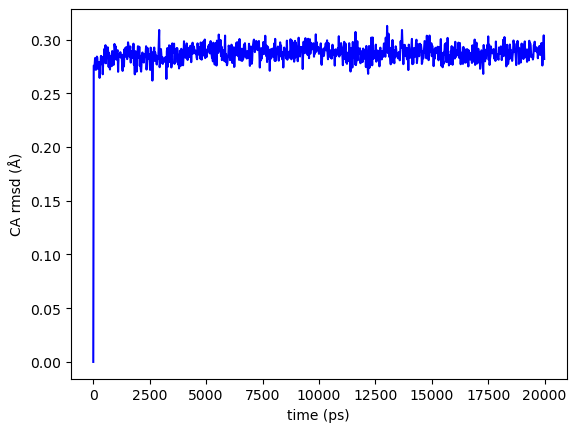

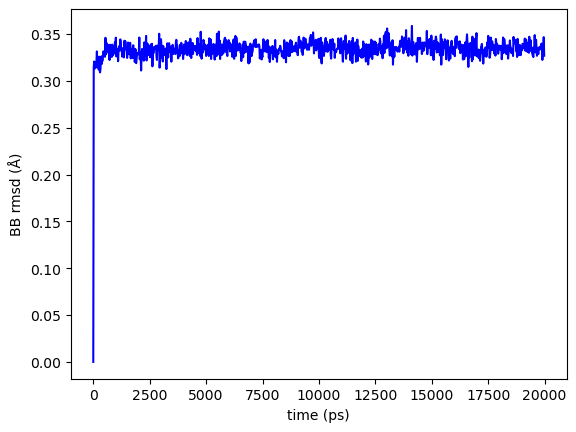

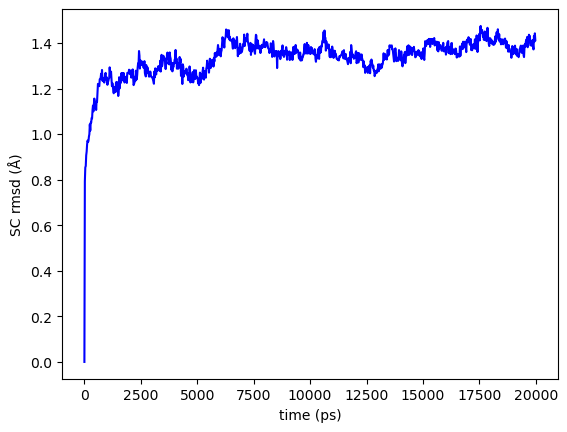

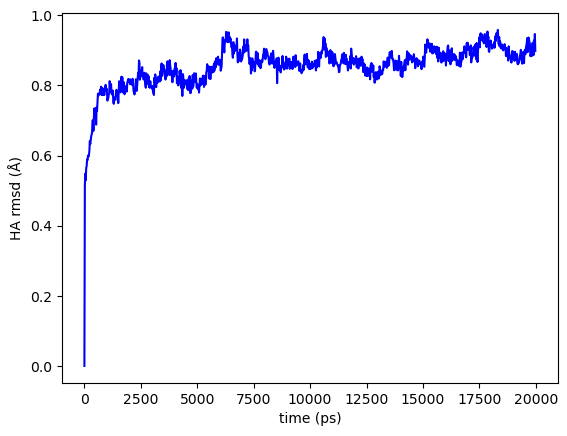

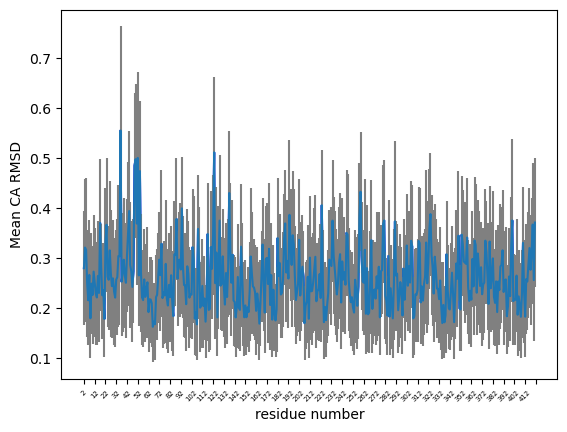

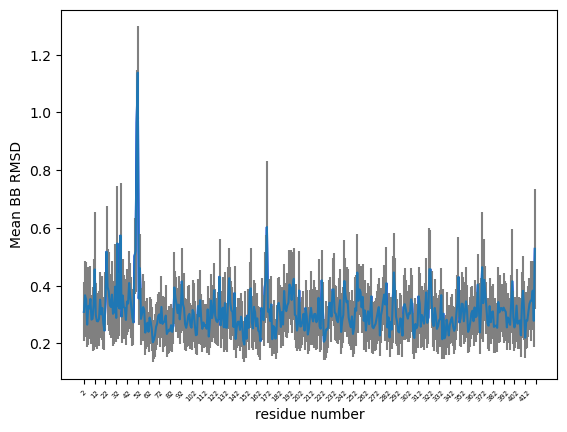

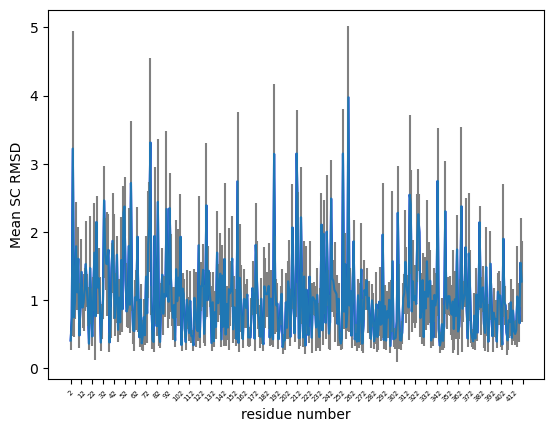

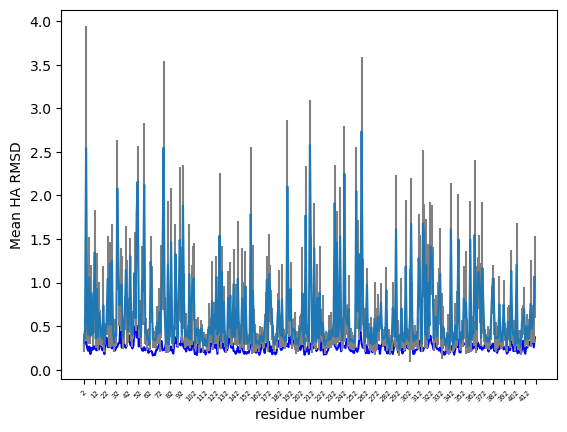

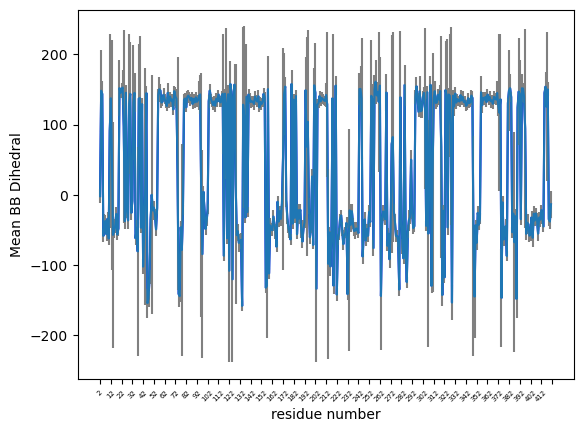

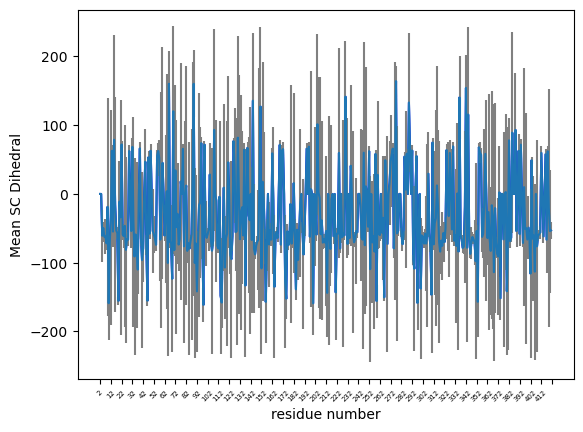

In [39]:
pA = proteinAnalysis(pdbfiles[0], out_dir, timestep = 20)
pA.loadTrajectory(trajectories[0], topologies[0])
pA.plotProteinRMSD()
pA.plotByResRMSD()
pA.plotByResDih()